# Déployez un modèle dans le cloud

In [ ]:
!pip install matplotlib
!pip install seaborn+

In [1]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf

from pyspark.sql import SparkSession
from pyspark.sql.functions import input_file_name, regexp_extract
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans

2025-05-22 00:01:14.380997: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 00:01:14.567432: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 00:01:14.659589: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747864874.746760   15367 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747864874.790194   15367 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747864874.974409   15367 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

On initialise une session Spark avec un nom d’application Fruits_Featurization. Cela permet d'exécuter les opérations de traitement de données en mode distribué via PySpark.

In [2]:
spark = SparkSession.builder \
    .appName("Fruits_Featurization") \
    .getOrCreate()

print("✅ Spark lancé :", spark.version)

25/05/22 00:01:22 WARN Utils: Your hostname, SUPER-INES resolves to a loopback address: 127.0.1.1; using 172.20.235.203 instead (on interface eth0)
25/05/22 00:01:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/22 00:01:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


✅ Spark lancé : 3.4.1


Spark lit les fichiers d’image au format binaire. Ensuite, on extrait le nom du dossier parent (ex : Banana) à partir du chemin du fichier, ce qui sert d’étiquette (label) pour chaque image.

In [3]:
# 🔁 Lecture des images avec sous-dossiers comme classes
image_dir = "file:///mnt/c/Users/inesn/OneDrive - Université de Paris/projet8/images_test/*/*.jpg"

df_images = spark.read.format("binaryFile").load(image_dir)

# 🏷️ Extraire le nom du dossier parent comme label
df_images = df_images.withColumn(
    "label",
    regexp_extract(input_file_name(), r"/images_test/([^/]+)/[^/]+\.jpg", 1)
)

df_images.select("path", "label").show(5, truncate=False)

+-------------------------------------------------------------------------------------------+-----+
|path                                                                                       |label|
+-------------------------------------------------------------------------------------------+-----+
|file:/mnt/c/Users/inesn/OneDrive - Université de Paris/projet8/images_test/Lemon/10_100.jpg|Lemon|
|file:/mnt/c/Users/inesn/OneDrive - Université de Paris/projet8/images_test/Lemon/2_100.jpg |Lemon|
|file:/mnt/c/Users/inesn/OneDrive - Université de Paris/projet8/images_test/Lemon/1_100.jpg |Lemon|
|file:/mnt/c/Users/inesn/OneDrive - Université de Paris/projet8/images_test/Lemon/0_100.jpg |Lemon|
|file:/mnt/c/Users/inesn/OneDrive - Université de Paris/projet8/images_test/Lemon/11_100.jpg|Lemon|
+-------------------------------------------------------------------------------------------+-----+
only showing top 5 rows



On charge le modèle pré-entraîné MobileNetV2, connu pour être léger et efficace. Chaque image est prétraitée puis passée dans ce modèle pour obtenir un vecteur de caractéristiques (embedding).

In [4]:
# Charger MobileNetV2 une seule fois
mobilenet = tf.keras.applications.MobileNetV2(
    include_top=False,
    pooling='avg',
    input_shape=(100, 100, 3),
    weights='imagenet'
)

# Télécharger les images (en mémoire)
local_data = df_images.select("label", "content").collect()

features = []
labels = []

for row in local_data:
    try:
        # Ouverture et prétraitement de l'image
        image = Image.open(io.BytesIO(row["content"])).convert("RGB").resize((100, 100))
        arr = tf.keras.preprocessing.image.img_to_array(image)
        arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
        
        # Extraire le vecteur de features
        feat = mobilenet.predict(np.expand_dims(arr, axis=0), verbose=0)[0]
        features.append(feat.tolist())
        labels.append(row["label"])
    
    except Exception as e:
        print("❌ Erreur sur une image :", e)

/tmp/ipykernel_15367/2790779799.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = tf.keras.applications.MobileNetV2(
E0000 00:00:1747864895.687586   15367 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1747864895.688538   15367 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
print(f"✅ {len(features)} images traitées. Exemple de vecteur :\n")
print(features[0])

✅ 15 images traitées. Exemple de vecteur :

[0.17551597952842712, 0.0, 0.0, 0.0, 0.0, 0.0, 2.740548610687256, 0.0, 1.6688494682312012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.04927206039428711, 0.0, 0.0, 0.2676278054714203, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.21148499846458435, 1.7050237655639648, 0.0, 0.0, 0.0, 0.0, 2.1523191928863525, 0.25256896018981934, 0.17248031497001648, 2.340850591659546, 0.0, 0.4740750789642334, 0.0, 0.0, 0.0, 0.0, 0.0, 3.443213939666748, 2.287872076034546, 0.0, 0.0, 0.0, 2.402831554412842, 0.0, 0.004755973815917969, 0.0, 0.26583272218704224, 0.05788353085517883, 0.0, 0.06566140055656433, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5996397733688354, 0.0, 0.30190086364746094, 0.0, 0.0, 1.1304856538772583, 0.2085024118423462, 0.0, 0.0, 0.04568400979042053, 0.12908250093460083, 0.0, 0.0, 0.0, 0.06752583384513855, 0.0, 0.0, 0.0, 0.21625488996505737, 0.0, 0.023888885974884033, 0.0, 0.5513583421707153, 0.42127305269241333, 0.8571999073028564, 0.0, 0.0, 0.0, 0.

On transforme les vecteurs extraits en un DataFrame Pandas temporaire, puis on le convertit en DataFrame Spark. On a alors une ligne par image avec ses features et son label.

In [6]:
# 🔄 DataFrame pandas temporaire
df_pd = pd.DataFrame({
    "label": labels,
    "features": features
})

# 🔄 Convertir en DataFrame Spark
df_spark = spark.createDataFrame(df_pd)

df_spark.printSchema()
df_spark.show(3, truncate=False)


root
 |-- label: string (nullable = true)
 |-- features: array (nullable = true)
 |    |-- element: double (containsNull = true)



+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Les modèles Spark ML (PCA, KMeans...) nécessitent que les features soient au format DenseVector. Cette étape transforme la liste de floats en un vecteur compatible.

In [7]:
# UDF pour transformer les listes en DenseVector
to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())

# Appliquer la transformation
df_vectorized = df_spark.withColumn("features_vec", to_vector_udf("features"))

df_vectorized.select("label", "features_vec").show(2, truncate=False)

[Stage 6:===================>                                       (1 + 2) / 3]

+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

On applique une analyse en composantes principales (PCA) pour réduire le nombre de dimensions à 50, tout en conservant l'information la plus importante. Cela améliore les performances des algorithmes en aval.

In [8]:
pca = PCA(k=50, inputCol="features_vec", outputCol="features_pca")
model = pca.fit(df_vectorized)
df_pca = model.transform(df_vectorized)

df_pca.select("label", "features_pca").show(2, truncate=False)

25/05/22 00:01:56 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/05/22 00:01:58 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


+-----+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|feature

Les vecteurs PCA sont sauvegardés dans un dossier local au format JSON. Cela permet de réutiliser les résultats sans avoir à relancer tout le traitement.

In [9]:
df_pca.select("label", "features_pca") \
      .write.mode("overwrite") \
      .json("file:///mnt/c/output/pca_features/")

On applique un algorithme de clustering non supervisé (KMeans) pour regrouper les fruits en 3 groupes. Chaque image se voit assigner un cluster.

In [10]:
kmeans = KMeans(featuresCol="features_pca", predictionCol="cluster", k=3)
model = kmeans.fit(df_pca)
df_clusters = model.transform(df_pca)

df_clusters.select("label", "cluster").show()

+--------------------+-------+
|               label|cluster|
+--------------------+-------+
|               Lemon|      1|
|               Lemon|      1|
|               Lemon|      1|
|               Lemon|      1|
|               Lemon|      1|
|Apple%20Red%20Del...|      2|
|Apple%20Red%20Del...|      2|
|Apple%20Red%20Del...|      2|
|Apple%20Red%20Del...|      2|
|Apple%20Red%20Del...|      2|
|              Banana|      0|
|              Banana|      0|
|              Banana|      0|
|              Banana|      0|
|              Banana|      0|
+--------------------+-------+



On récupère les données localement pour créer un DataFrame Pandas contenant les 2 premières composantes PCA et le cluster associé, pour affichage.

In [11]:
# Recueillir les résultats localement
rows = df_clusters.select("label", "cluster", "features_pca").collect()

# Construire un DataFrame pandas manuellement
pdf = pd.DataFrame([{
    "label": row["label"],
    "cluster": row["cluster"],
    "x": row["features_pca"][0],
    "y": row["features_pca"][1]
} for row in rows])

On trace un scatter plot des fruits selon les 2 premières composantes PCA, colorés par cluster. Cela permet de visualiser la séparation des groupes trouvés par KMeans.

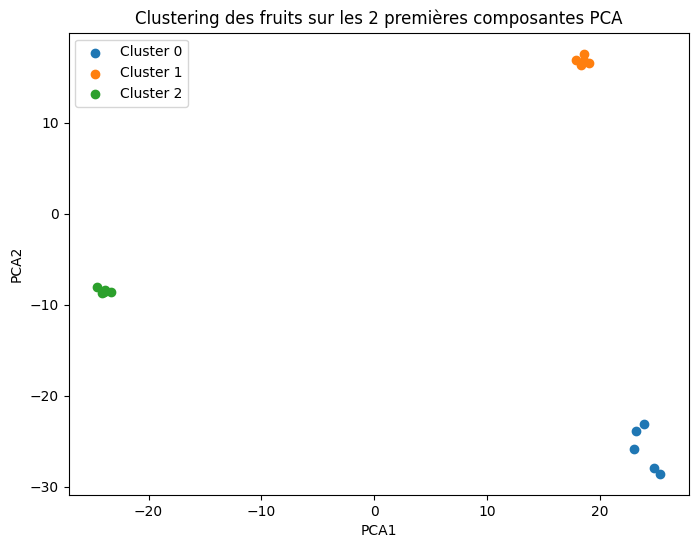

In [12]:
plt.figure(figsize=(8, 6))
for cluster_id in sorted(pdf["cluster"].unique()):
    subset = pdf[pdf["cluster"] == cluster_id]
    plt.scatter(subset["x"], subset["y"], label=f"Cluster {cluster_id}")
plt.legend()
plt.title("Clustering des fruits sur les 2 premières composantes PCA")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

On crée un graphique de comptage pour voir la répartition des vrais labels dans chaque cluster. Cela permet d’évaluer si les clusters correspondent bien aux catégories réelles (banane, citron, pomme…).

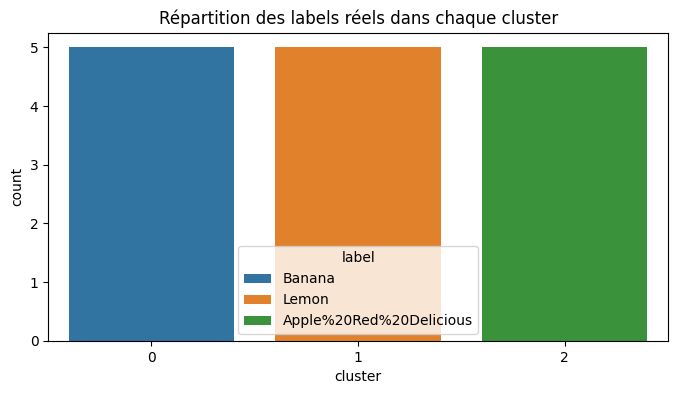

In [13]:
plt.figure(figsize=(8, 4))
sns.countplot(data=pdf, x="cluster", hue="label")
plt.title("Répartition des labels réels dans chaque cluster")
plt.show()

## ✅ Conclusion du traitement Big Data - Projet *Fruits!*

- Les images de fruits ont été correctement lues et étiquetées à partir de leur chemin.
- Une featurisation par MobileNetV2 a permis d’obtenir des vecteurs de caractéristiques pertinents.
- Une réduction de dimension par **PCA à 50 composantes** a été appliquée.
- Un clustering **non supervisé (KMeans k=3)** a mis en évidence **trois groupes distincts**, visuellement séparés.
- Les résultats sont cohérents avec les types de fruits présents dans le jeu de données.
- L’ensemble de la chaîne a été réalisée en PySpark, compatible avec un futur déploiement EMR.

🎯 Prochaine étape : tester cette chaîne à grande échelle sur Amazon EMR avec lecture depuis S3, traitement distribué, et respect du RGPD.